## Text Mining of the Product Reviews

### Preparation

#### Read in packages

In [2166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud.wordcloud import WordCloud, STOPWORDS
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
import gender_guesser.detector as gender
import warnings
warnings.filterwarnings("ignore")
from dask import compute, delayed
import dask.multiprocessing
import multiprocessing
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import six
import statsmodels.api as sm
from sklearn.tree import export_graphviz
import graphviz
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
import yaml
import textstat
from scipy.stats import rankdata
import copy

sns.set(style="whitegrid")
plt.style.use('seaborn-deep')

#pd.set_option('display.max_colwidth', 1)
start=time.time()

#### Read in data

Sample product link:

https://www.amazon.com/Microsoft-Natural-Ergonomic-Keyboard-4000/dp/B000A6PPOK/ref=sr_1_3?dchild=1&keywords=Microsoft%2BNatural%2BErgonomic%2BKeyboard%2Bretail&qid=1585149060&sr=8-3&th=1#customerReviews

In [2167]:
df = pd.read_csv("sample.csv")
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.drop(['asin'], axis = 1, inplace = True)
df = df.rename(columns={'overall': 'Rating'})
df_original = copy.deepcopy(df)  
df.head(3)

,Rating,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,"1,113",True,"10 18, 2005",AILCWT1IIP7ZT,{'Style:': ' Retail'},Charles Chen,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,1129593600,NaN
1,5.0,16,True,"10 12, 2005",A300T403J8526F,{'Style:': ' Retail'},T. Becker,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,1129075200,NaN
2,4.0,11,True,"10 5, 2005",AFPGV3IQ9K691,{'Style:': ' Retail'},GDC,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",1128470400,NaN


In [2168]:
df['unixReviewTime'].min(), df['unixReviewTime'].max()

(1128470400, 1526688000)

In [2169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 11 columns):
Rating            2567 non-null float64
vote              174 non-null object
verified          2567 non-null bool
reviewTime        2567 non-null object
reviewerID        2567 non-null object
style             2554 non-null object
reviewerName      2567 non-null object
reviewText        2567 non-null object
summary           2567 non-null object
unixReviewTime    2567 non-null int64
image             13 non-null object
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 203.2+ KB


#### Word Cloud

WORDS=[]
for i in range(df.shape[0]):
    words=df["reviewText"].astype('str').iloc[i].split(";")
    for word in words:
        WORDS.append(word)

wc = WordCloud(stopwords=STOPWORDS,background_color='white',
               width=6000,height=5000).generate(" ".join(set(WORDS)))
plt.imshow(wc)
plt.title("Word Cloud Visualization of Sample Reviews")
plt.axis('off')
plt.savefig("plots/tagswordcloud.png")

#### Text cleaning & pre-processing

__Tokenization__: Split the text into sentences and the sentences into words. 

__Lowercase__ the words and __remove punctuation__.

Words that have fewer than 3 characters are removed.

All __stopwords__ are removed.

Words are __lemmatized__: words in third person are changed to first person and verbs in past and future tenses are changed into present.

Words are __stemmed__: words are reduced to their root form.

Reference: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [2170]:
np.random.seed(2018)

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lliu9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Functions to perform lemmatize and stem preprocessing steps

In [2171]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [2172]:
df.iloc[10]['reviewText']

"Absolutely love this keyboard.  I had an older one and the letters were worn off.  Didn't bother me, but my wife was very pleased when she saw that it had the letters still on the keys.  This keyboard feels great and is just designed so well."

In [2173]:
doc_sample = df.iloc[10]['reviewText']
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
    
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Absolutely', 'love', 'this', 'keyboard.', '', 'I', 'had', 'an', 'older', 'one', 'and', 'the', 'letters', 'were', 'worn', 'off.', '', "Didn't", 'bother', 'me,', 'but', 'my', 'wife', 'was', 'very', 'pleased', 'when', 'she', 'saw', 'that', 'it', 'had', 'the', 'letters', 'still', 'on', 'the', 'keys.', '', 'This', 'keyboard', 'feels', 'great', 'and', 'is', 'just', 'designed', 'so', 'well.']


 tokenized and lemmatized document: 
['absolut', 'love', 'keyboard', 'older', 'letter', 'wear', 'bother', 'wife', 'pleas', 'letter', 'key', 'keyboard', 'feel', 'great', 'design']


##### Preprocess the data

In [2174]:
processed_docs = df['reviewText'].map(preprocess)
processed_docs[:10]

0    [softwar, develop, liter, attach, keyboard, ty...
1    [natur, keyboard, year, work, look, home, keyb...
2    [microsoft, product, great, hardwar, poor, sof...
3                                               [love]
4               [version, keyboard, year, save, wrist]
5                                             [pefect]
6    [plug, work, like, champ, keyboard, take, get,...
7                         [instal, year, work, expect]
8    [like, like, split, half, board, like, challen...
9         [type, word, minut, unit, fifth, year, love]
Name: reviewText, dtype: object

##### Bag of words & Filter out infrequent tokens

In [2175]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below = 10, no_above = 0.5, keep_n = 100000)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abl
1 actual
2 addit
3 adjust
4 appreci
5 attach
6 avail
7 base
8 begin
9 best
10 better


##### doc2bow
how many words and how many times those words appear in one document

In [2176]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[10]

bow_doc = bow_corpus[10]
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0], 
                                               dictionary[bow_doc[i][0]], 
bow_doc[i][1]))

Word 42 ("feel") appears 1 time.
Word 63 ("key") appears 1 time.
Word 71 ("love") appears 1 time.
Word 88 ("older") appears 1 time.
Word 226 ("design") appears 1 time.
Word 237 ("great") appears 1 time.
Word 322 ("absolut") appears 1 time.
Word 323 ("bother") appears 1 time.
Word 324 ("letter") appears 2 time.
Word 325 ("pleas") appears 1 time.
Word 326 ("wear") appears 1 time.
Word 327 ("wife") appears 1 time.


##### TF-IDF (frequency-inverse document frequency)

how important a word is to a document in a collection or corpus

In [2177]:
tfidf = models.TfidfModel(bow_corpus)
corpus = tfidf[bow_corpus]
#for doc in corpus:
#    pprint(doc)
#    break

### Features: Latent Topics

#### LDA using Bag of Words

In [2178]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 10, 
                                           random_state = 100,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',       
                                           per_word_topics = True)

In [2179]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

Topic: 0 
Word: 0.068*"quick" + 0.049*"support" + 0.042*"caus" + 0.037*"store" + 0.033*"tire" + 0.032*"regist" + 0.032*"hold" + 0.031*"includ" + 0.030*"real" + 0.029*"period"
Topic: 1 
Word: 0.105*"qualiti" + 0.070*"tilt" + 0.063*"wife" + 0.048*"link" + 0.042*"near" + 0.036*"adapt" + 0.032*"default" + 0.030*"mistak" + 0.028*"rat" + 0.027*"busi"
Topic: 2 
Word: 0.025*"space" + 0.022*"ergonom" + 0.021*"natur" + 0.020*"feel" + 0.016*"ergo" + 0.016*"year" + 0.014*"love" + 0.014*"replac" + 0.014*"nice" + 0.013*"littl"
Topic: 3 
Word: 0.036*"mous" + 0.034*"wireless" + 0.032*"easi" + 0.031*"quiet" + 0.027*"posit" + 0.025*"perfect" + 0.024*"desk" + 0.023*"regular" + 0.023*"second" + 0.021*"order"
Topic: 4 
Word: 0.022*"work" + 0.021*"microsoft" + 0.018*"key" + 0.018*"like" + 0.016*"button" + 0.015*"time" + 0.014*"comfort" + 0.013*"press" + 0.013*"buy" + 0.012*"problem"
Topic: 5 
Word: 0.091*"thumb" + 0.064*"spill" + 0.048*"lose" + 0.044*"complet" + 0.042*"suggest" + 0.041*"clean" + 0.038*"emai

#### Model Perplexity and Coherence Score

 judge how good a given topic model is

In [2180]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = processed_docs, dictionary = dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.94617890712126

Coherence Score:  0.3832561678525589


### Optimal number of topics for LDA 

In [2213]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#comment out as execution takes a while

limit = 10; start = 3; step = 1;

model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus, texts=processed_docs, 
                                                        start=start, limit=limit, step=step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Optimal Number of Topics by LDA Model')
plt.savefig("Optimal Number of Topics by LDA Model.png")

opt_topics = np.argmax(coherence_values)+start

opt_topics

##### Topic proportions as features

In [2220]:
lda_model_opt = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                             id2word = dictionary,
                                           num_topics = opt_topics, 
                                           random_state = 10,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',       
                                           per_word_topics = True)

In [2075]:
props = []
for ind in range(len(corpus)):
    props.append([i[1].round(5) for i in lda_model_opt.get_document_topics(corpus[ind])])

#### Topics Visualization

In [2221]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_opt, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.260274  0.138510       1        1  59.143211
3     -0.275960  0.150084       2        1  20.890774
1     -0.014934 -0.311792       3        1  18.173773
2      0.030620  0.023198       4        1   1.792247, topic_info=    Category       Freq      Term      Total  loglift  logprob
9    Default  42.000000      best  42.000000  30.0000  30.0000
185  Default  40.000000      home  40.000000  29.0000  29.0000
189  Default  38.000000      look  38.000000  28.0000  28.0000
195  Default  36.000000   product  36.000000  27.0000  27.0000
292  Default  38.000000  spacebar  38.000000  26.0000  26.0000
..       ...        ...       ...        ...      ...      ...
557   Topic4   0.145907    discov   4.453496   0.6032  -7.0431
427   Topic4   0.144323      pull   3.954710   0.7111  -7.0540
702   Topic4   0.146486    latest   5.420900   0.4106  -7.0391
198   Topic4   0.146102    revers   6.206793   0.2726  -7.0417
57    Topic4   0.145020   impress   6.290681   0.2517  -7.0492

[177 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         3  0.966566   actual
933       1  0.780564  address
859       1  0.651945    align
207       2  0.994782    allow
209       3  0.943143    annoy
...     ...       ...      ...
338       3  0.937393    worth
161       1  0.984652    wrist
534       4  0.683557   writer
162       1  0.961900     year
162       3  0.040932     year

[157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

Topic 1: functionality (work, type, time, wrist, space)
    
Topic 2: user experience (key, like, button, feel, design)

Topic 3: brand and product name (microsoft, nature, comfort, ergonomic, good)

Topic 4: feelings (great, best, spacebar, product, space)

Topic 5: compatibility (mouse, board, perfect, driver, experience)
    

In [2077]:
df["Topic1_functionality"] = [i[0] for i in props]
df["Topic2_user experience"] = [i[1] for i in props]
df["Topic3_brand name"] = [i[2] for i in props]
df["Topic4_feelings"] = [i[3] for i in props]
df["Topic5_compatibility"] = [i[4] for i in props]

### Features engineering

#### Get the number of associated images

In [2078]:
def imagenum(df):
    """
    Outputs the number of images from the `image` column
    """
    if type(df['image']) == float:
        return 0
    else:
        return len(df['image'])

df['Imagenum'] = df.apply(imagenum, axis=1)

In [2079]:
# % of reviews don't have images
len(df[df['Imagenum']==0])/df.shape[0]

0.9949357226334242

#### Get the indicator of being verified or not

In [2080]:
def verified(df):
    """
    Outputs the indicator (1/0) from the `verified` column
    """
    if df['verified'] == True:
        return 1
    else:
        return 0
    
df['Verified'] = df.apply(verified, axis=1)

In [2081]:
df['verified'].value_counts()
df['verified'].value_counts()/df.shape[0]

True     0.862875
False    0.137125
Name: verified, dtype: float64

In [2082]:
# Verified reviews have higher average scores
df.groupby(['verified']).mean()['Rating']

verified
False    3.593750
True     4.303837
Name: Rating, dtype: float64

#### Get the indicator of using a real name

One tried approach: named entities extraction

Pbm: cannot tell the real or seemingly-real names

https://towardsdatascience.com/custom-named-entity-recognition-using-spacy-7140ebbb3718

https://spacy.io/usage/linguistic-features#named-entities

Approach: return true if the `revierName` has verfied first names by gender guesser (not unknown in the name database), (middle name), and last name 

https://pypi.org/project/gender-guesser/

In [2083]:
def nameverified(df):
    """
    Output the indicator (1/0) from the `reviewerName` column 
    """
    try:
        parts = df['reviewerName'].split(' ')
        if len(parts) >= 2:
            if gender.Detector().get_gender(parts[0]) != 'unknown': 
                return 1
        else:
            return 0
    except AttributeError:
        return 0

df['Nameverified'] = df.apply(nameverified, axis=1)
df['Nameverified'] = df['Nameverified'].fillna(0)

In [2084]:
df['Nameverified'].value_counts()

0.0    1744
1.0     823
Name: Nameverified, dtype: int64

#### Sentiment

In [2085]:
def sentiment(df):
    """
    Outputs the sentiment score for each review
    """
    return analyser.polarity_scores(df['reviewText'])['compound']

df['Sentiment'] = df.apply(sentiment, axis=1)

In [2086]:
# Sentiment scores are positively correlated with the overall rating, but the correlation is not strong
round(np.corrcoef(df['Rating'],  df["Sentiment"])[0,1],3)

0.376

In [2087]:
df['Sentiment'].describe()

count    2567.000000
mean        0.454418
std         0.539726
min        -0.994900
25%         0.144700
50%         0.636900
75%         0.877700
max         0.999500
Name: Sentiment, dtype: float64

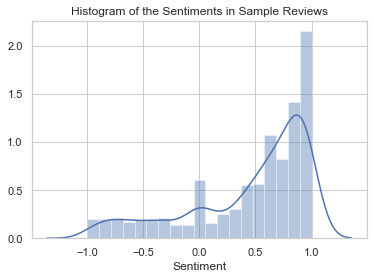

In [2088]:
sns.distplot(df['Sentiment'])
plt.title("Histogram of the Sentiments in Sample Reviews")
plt.savefig('Plots/Sentiments')

#### Length

https://pypi.org/project/textstat/

In [2089]:
def length(df):
    """
    Output the lexicon counts for each review
    """
    return textstat.lexicon_count(df['reviewText'], removepunct = True)

df['Length'] = df.apply(length, axis=1)

In [2090]:
df['Length'].describe()

count    2567.000000
mean       81.370861
std       103.028761
min         0.000000
25%        20.000000
50%        49.000000
75%       102.000000
max      1179.000000
Name: Length, dtype: float64

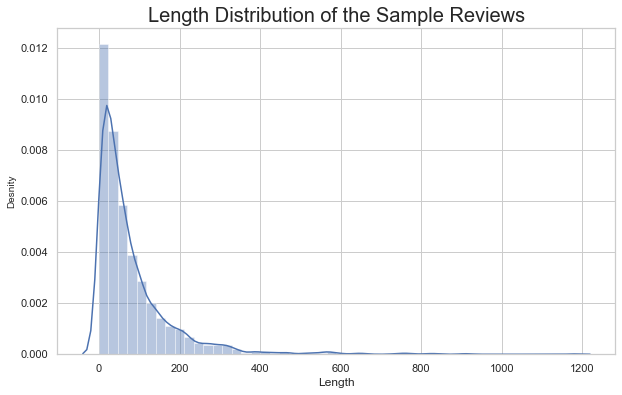

In [2091]:
plt.figure(figsize=(10,6))
sns.distplot(df['Length'])
plt.ylabel('Desnity', fontsize=10)
plt.title('Length Distribution of the Sample Reviews', fontsize=20)
plt.savefig('Plots/Length Distribution of the Sample Reviews.png')

#### Digits count

In [2092]:
df['Digits'] = df_original['reviewText'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

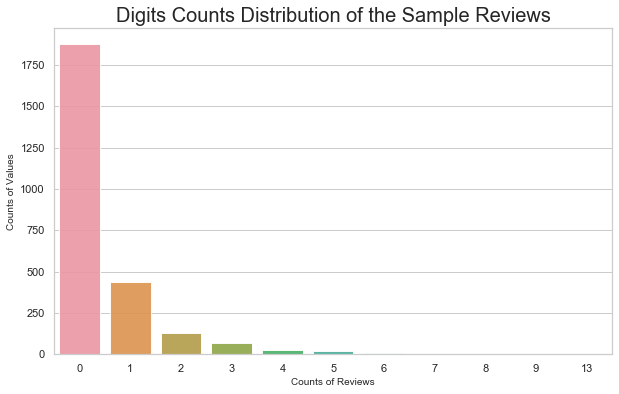

In [2093]:
sns.set_color_codes("muted")
df['Digits'].value_counts().index
Digits = pd.DataFrame({'Index':df['Digits'].value_counts().index, 'Values':df['Digits'].value_counts().values})
plt.figure(figsize=(10,6))
sns.barplot( x="Index", y="Values", data = Digits, alpha=0.9)
plt.ylabel('Counts of Values', fontsize=10)
plt.xlabel('Counts of Reviews', fontsize=10)
plt.xticks(rotation=0)
plt.title('Digits Counts Distribution of the Sample Reviews', fontsize=20)
plt.savefig('Plots/Digits Counts Distribution of the Sample Reviews.png')

#### Flesch reading ease score

In [2094]:
def flesch(df):
    """
    Output the Flesch reading ease score for each review
    """
    return textstat.flesch_reading_ease(df['reviewText'])

df['Readability'] = df.apply(flesch, axis=1)

In [2095]:
df['Readability'].describe()

count    2567.000000
mean       54.324063
std        65.756029
min     -1108.300000
25%        46.440000
50%        71.480000
75%        83.660000
max       206.840000
Name: Readability, dtype: float64

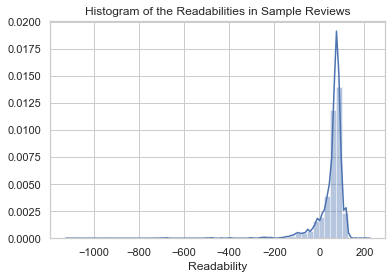

In [2096]:
sns.distplot(df['Readability'])
plt.title("Histogram of the Readabilities in Sample Reviews")
plt.savefig('Plots/readability')

#### Number of spelling mistakes

https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/

In [2097]:
from textblob import TextBlob
 
data = "Natural language is a cantral part of our day to day life, and it's so antresting to work on any problem related to langages."
 
output = TextBlob(df['reviewText'].iloc[0]).correct()
print(output)

Is a software developer, I am literally attached to my keyboard.  In a typical day, I'll spend anywhere between 5-8 hours tying, so it's of critical importance that the keyboard I use is comfortable.  Is most programme and twists can fattest, the Microsoft Go series of keyboard is the best keyboard for prolonged use.

Having used the Go keyboard in some form or another for the past 4 years (most recently, the Tireless Elite set), I must say that this keyboard is a step above.

To begin with, the construction is very solid.  There is far less flex in the plastic and the keyboard as a whole compared to my Tireless Elite.  The wrist pad is made of a nicely texture faut leather material with a tiny bit of adding.  It feels rather unable (not to mention comfortable).  It's a good addition as one of my main grapes with the of ergot keyboard was that it was hard to fit one of those get wrist rests around the curved base of the keyboard.

Compared to previous of keyboard that I've owned, the k

In [2098]:
output.words[100].spellcheck()

[('in', 1.0)]

In [2099]:
from textblob import Word
w = Word('\n\nSizewise')
w.spellcheck()

[('\n\nSizewise', 0.0)]

In [2100]:
df['reviewText'].iloc[0]

'As a software developer, I am literally attached to my keyboard.  On a typical day, I\'ll spend anywhere between 5-8 hours typing, so it\'s of critical importance that the keyboard I use is comfortable.  As most programmers and typists can attest, the Microsoft Ergo series of keyboards is the best keyboard for prolonged use.\n\nHaving used the Ergo keyboards in some form or another for the past 4 years (most recently, the Wireless Elite set), I must say that this keyboard is a step above.\n\nTo begin with, the construction is very solid.  There is far less flex in the plastic and the keyboard as a whole compared to my Wireless Elite.  The wrist pad is made of a nicely textured faux leather material with a tiny bit of padding.  It feels rather durable (not to mention comfortable).  It\'s a good addition as one of my main gripes with the MS ergo keyboards was that it was hard to fit one of those gel wrist rests around the curved base of the keyboard.\n\nCompared to previous MS keyboards

#### Length of Summary

In [2101]:
def summary_length(df):
    """
    Output the length for each review summary
    """
    return textstat.lexicon_count(df['summary'], removepunct = True)

df['SummaryLength'] = df.apply(summary_length, axis=1)

In [2102]:
df['SummaryLength'].describe()

count    2567.000000
mean        5.081808
std         3.697275
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        28.000000
Name: SummaryLength, dtype: float64

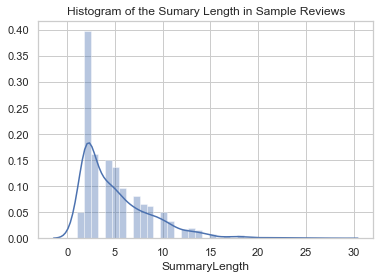

In [2103]:
sns.distplot(df['SummaryLength'])
plt.title("Histogram of the Sumary Length in Sample Reviews")
plt.savefig('Plots/SummaryLength')

#### Sentiment of Summary

In [2104]:
def summary_sentiment(df):
    """
    Outputs the sentiment score for each review summary
    """
    return analyser.polarity_scores(df['summary'])['compound']

df['SummarySentiment'] = df.apply(summary_sentiment, axis=1)

In [2105]:
df['SummarySentiment'].describe()

count    2567.000000
mean        0.268811
std         0.367739
min        -0.759600
25%         0.000000
50%         0.361200
75%         0.624900
max         0.950100
Name: SummarySentiment, dtype: float64

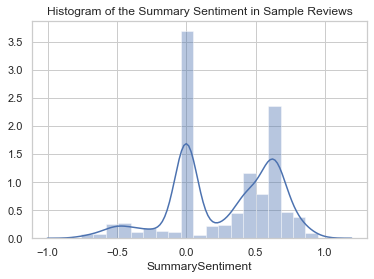

In [2106]:
sns.distplot(df['SummarySentiment'])
plt.title("Histogram of the Summary Sentiment in Sample Reviews")
plt.savefig('Plots/SummarySentiment')

#### Days since the first review

In [2107]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df['Days'] = df['unixReviewTime'] - df['unixReviewTime'].min()
df['Days'] = [i.days for i in df['Days']]

#### Before/After verified purchase policy

In [2108]:
def verified_option(df):
    """
    Output whether the review was written after the introduction of verified purchase label policy
    """
    if df['unixReviewTime'].date()> datetime(2016, 11, 1).date():
        return 1
    else:
        return 0

df['verified_option'] = df.apply(verified_option, axis=1)
round(100*sum(df['verified_option'])/len(df))

13

#### Styles (Different models)

In [2109]:
df['style'].value_counts()

{'Style:': ' Retail'}      1930
{'Style:': ' Business'}     624
Name: style, dtype: int64

In [2110]:
# This function is useful when there are multiple categories in 'style'
def style(df):
    """
    Output the style of the product
    """
    try:
        if 'Size:' in df['style']:
            return yaml.load(df['style'])['Style:']
    except:
        return 0

#df['style'] = df.apply(style, axis=1)
#df['Retail'] = np.where(df['style'] == "{'Style:': ' Retail'}", 1, 0)
#sum(df['Retail'])

#### Rating

In [2111]:
# positive reviews
(df['Rating'].value_counts().iloc[0] + df['Rating'].value_counts().iloc[1])/df.shape[0]

0.7892481495909622

In [2112]:
# neutral reviews
(df['Rating'].value_counts().iloc[2])/df.shape[0]

0.0802493182703545

In [2113]:
# negative reviews
(df['Rating'].value_counts().iloc[3]+df['Rating'].value_counts().iloc[4])/df.shape[0]

0.1305025321386833

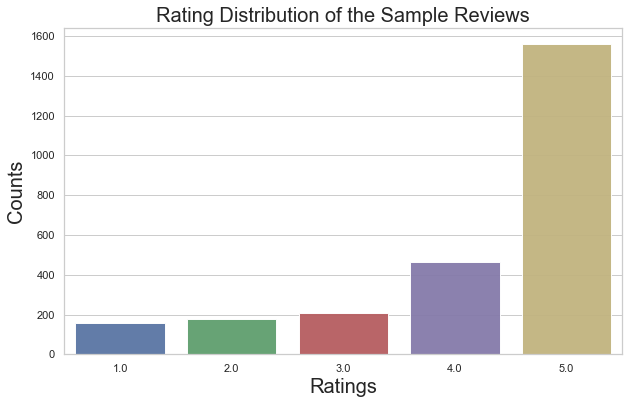

In [2114]:
cnt_rating = df['Rating'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(cnt_rating.index, cnt_rating.values, alpha=0.95)
plt.ylabel('Counts', fontsize=20)
plt.xlabel('Ratings', fontsize=20)
plt.xticks(rotation=0)
plt.title('Rating Distribution of the Sample Reviews', fontsize=20)
plt.savefig('Plots/Rating Distribution of the Sample Reviews.png')

### Trustworthness Score (y)

#### Convert vote variable to float type

In [2115]:
def cleanvote(df):
    """
    Outputs the votes as numerical values 
    """
    try:
        return float(df['vote'])
    except ValueError:
        return float(df['vote'].replace(',', ''))
    
df['vote'] = df.apply(cleanvote, axis=1)

In [2116]:
df['vote'].describe()

count     174.000000
mean       16.408046
std        90.983452
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max      1113.000000
Name: vote, dtype: float64

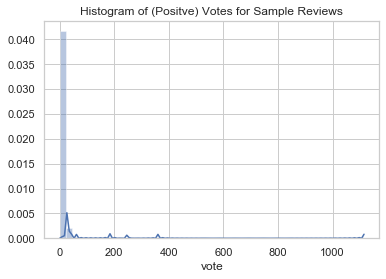

In [2117]:
sns.distplot(df[df['vote'].notnull()]['vote'])
plt.title('Histogram of (Positve) Votes for Sample Reviews')
plt.savefig('Plots/Histogram of (Positive) Votes for Sample Reviews.png')

In [2118]:
# % of reviews don't have any votes
df['vote'].isna().sum()/df.shape[0]

0.9322165952473704

In [2160]:
df_original[df_original['vote'].isna()]

,Rating,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
3,5.0,NaN,True,"05 15, 2018",A2FMMCFQ8702DN,{'Style:': ' Business'},Wickenball,Love it.,Five Stars,1526342400,NaN
4,5.0,NaN,True,"05 12, 2018",A1I8WBJSZIPJE0,{'Style:': ' Business'},B. Stearn,I've had various versions of this keyboard for...,Five Stars,1526083200,NaN
5,5.0,NaN,True,"05 12, 2018",A1CWLSHHR9KWHL,{'Style:': ' Business'},Roni Me,pefect for me,Five Stars,1526083200,NaN
6,5.0,NaN,True,"05 11, 2018",A3T7XVG3AXJF61,{'Style:': ' Business'},K. Miller,Plugged it in and it works like a champ. Keyb...,Special keys worked out of the box!,1525996800,NaN
7,4.0,NaN,True,"05 5, 2018",AV4PXSFL66YYL,{'Style:': ' Retail'},GEOFFREY B.,Has been installed for over a year and still i...,OK product,1525478400,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2554,2.0,NaN,True,"01 19, 2006",A3EVGPGOFVAP09,{'Style:': ' Retail'},WorknMan,I've been using this model keyboard for over 7...,BEWARE if you're replacing an old one,1137628800,NaN
2563,5.0,NaN,True,"05 19, 2018",A3NOZ4M9D1IIR7,{'Style:': ' Business'},john chamberlain,good,Five Stars,1526688000,NaN
2564,5.0,NaN,True,"05 17, 2018",A36WZAWDM2D487,{'Style:': ' Retail'},Amazon Customer,This is my second time purchasing this keyboar...,The keyboard is dropped on the floor 2 to 3 ti...,1526515200,NaN
2565,5.0,NaN,True,"05 16, 2018",ALZ9C6MTMF20E,{'Style:': ' Business'},D.J.,My favorite keyboard by far. Only issue is tha...,excellent product,1526428800,NaN


#### Position

In [2119]:
df['vote2'] = df['vote'] .fillna(0.001)

In [2120]:
df['page_index'] = np.ceil((df.index+1)/10)

In [2121]:
vote_by_pst = df.groupby(['page_index'])['vote2'].agg({'vote2':['mean']})
vote_by_pst.columns = ['mean']
vote_by_pst.head()

,mean
page_index,
1.0,114.0007
2.0,0.0010
3.0,0.0010
4.0,0.0010
5.0,0.0010


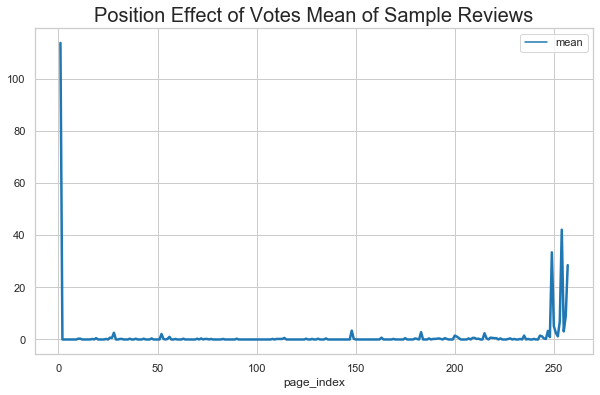

In [2122]:
plt.figure(figsize = (10,6))
sns.lineplot(data=vote_by_pst, palette="tab10", linewidth=2.5)
plt.title('Position Effect of Votes Mean of Sample Reviews', fontsize=20)
plt.savefig('Plots/Position Effect of Votes Mean of Sample Reviews.png')

#### Time

In [2123]:
df['Quarters'] = np.ceil(df['Days']/90)

In [2124]:
df['Year'] = df['unixReviewTime'].dt.year

In [2125]:
vote_by_yr = df.groupby(['Quarters'])['vote2'].agg({'vote2':['mean', 'count']})
vote_by_yr.columns = ['mean', 'count']
#vote_by_yr['rate'] = (vote_by_yr['mean'] - vote_by_yr['mean'].iloc[0])/vote_by_yr['mean'].iloc[0]
vote_by_yr.head(5)

,mean,count
Quarters,,
0.0,11.000000,1
1.0,137.800000,10
2.0,5.384846,13
3.0,6.667000,6
4.0,5.200200,5


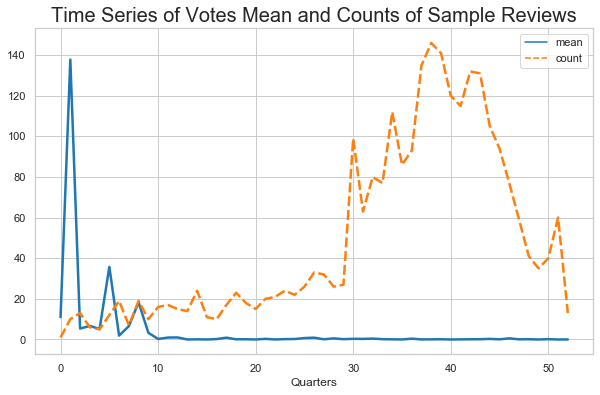

In [2126]:
plt.figure(figsize = (10,6))
sns.lineplot(data=vote_by_yr, palette="tab10", linewidth=2.5)
plt.title('Time Series of Votes Mean and Counts of Sample Reviews', fontsize=20)
plt.savefig('Plots/Time Series of Votes Mean and Counts of Sample Reviews.png')

#### Correction


Two sources of bias:

1. Time

The reviews range from 2005 to 2018. It is likely older reviews exist in the platform longer and have moe exposures, while the newer reviews are less read by the customers. It is important to re-estimate the actual votes of the reviews by taking the time factor into account.

2. Position

The reviews displayed on top could receive more views and votes.

Model:

$Actual\ vote \propto Current * Quarters * Index $

Intuition: When quarter increases, the votes should increase to compensate for the shorter time of being read. When page index increases, the votes should increase to compensate for the fewer opportuities of being read. 

In [2127]:
vote_re = pd.DataFrame({'vote':df['vote2'], 'Quarter':df['Quarters'], 'Index':df['page_index']})
vote_re = pd.DataFrame(scaler.fit_transform(vote_re), columns=['vote','quarter','index'])
vote_re['vote'] = vote_re['vote']+1e-20  # make the votes no-zero so that the correction rates could have an impat
vote_re

,vote,quarter,index
0,1.000000e+00,0.019231,0.0
1,1.437468e-02,0.019231,0.0
2,9.882309e-03,0.000000,0.0
3,1.000000e-20,1.000000,0.0
4,1.000000e-20,1.000000,0.0
...,...,...,...
2562,9.882309e-03,0.019231,1.0
2563,1.000000e-20,1.000000,1.0
2564,1.000000e-20,1.000000,1.0
2565,1.000000e-20,1.000000,1.0


In [2128]:
vote_re['score'] = vote_re['vote']*(1+vote_re['quarter']+vote_re['index'])

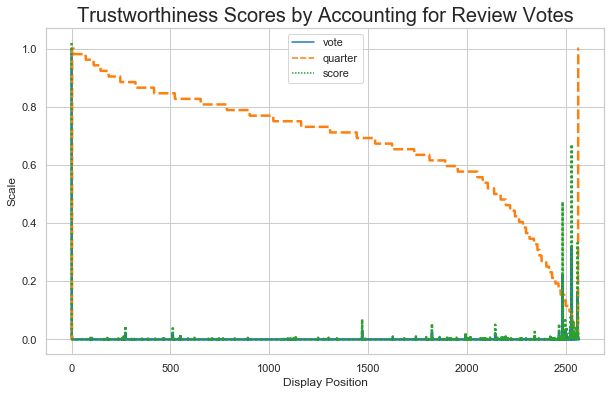

In [2165]:
plt.figure(figsize = (10,6))
sns.lineplot(data=vote_re[['vote', 'quarter', 'score']], palette="tab10", linewidth=2.5)
plt.title('Trustworthiness Scores by Accounting for Review Votes', fontsize=20)
plt.xlabel('Display Position')
plt.ylabel('Scale')
plt.savefig('Plots/Trustworthiness Scores by Accounting for Review Votes.png', fontsize=20)

In [2130]:
df['score'] = vote_re['score'].rank()

### Exploratory Data Analysis 

#### Select features by theory

In [2131]:
df.columns

Index(['Rating', 'vote', 'verified', 'reviewTime', 'reviewerID', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'image',
       'Topic1_functionality', 'Topic2_user experience', 'Topic3_brand name',
       'Topic4_feelings', 'Topic5_compatibility', 'Imagenum', 'Verified',
       'Nameverified', 'Sentiment', 'Length', 'Digits', 'Readability',
       'SummaryLength', 'SummarySentiment', 'Days', 'verified_option', 'vote2',
       'page_index', 'Quarters', 'Year', 'score'],
      dtype='object')

In [2132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 32 columns):
Rating                    2567 non-null float64
vote                      174 non-null float64
verified                  2567 non-null bool
reviewTime                2567 non-null object
reviewerID                2567 non-null object
style                     2554 non-null object
reviewerName              2567 non-null object
reviewText                2567 non-null object
summary                   2567 non-null object
unixReviewTime            2567 non-null datetime64[ns]
image                     13 non-null object
Topic1_functionality      2567 non-null float64
Topic2_user experience    2567 non-null float64
Topic3_brand name         2567 non-null float64
Topic4_feelings           2567 non-null float64
Topic5_compatibility      2567 non-null float64
Imagenum                  2567 non-null int64
Verified                  2567 non-null int64
Nameverified              2567 non-null

In [2133]:
features = ['Rating', 'Imagenum', 'Nameverified', 'Verified',         # objective reviewers' info
            'Topic1_functionality', 'Topic2_user experience', 'Topic3_brand name', 'Topic4_feelings', 'Topic5_compatibility', # latent topics
            'Sentiment', 'Length', 'Digits', 'Readability',           # characteristics of reviews
            'SummaryLength', 'SummarySentiment']                      # characteristics of reviews summary

#### Summary statistics

In [2134]:
df.drop(['style', 'reviewerID', 'reviewerName', 
         'image', 'reviewTime',], axis=1, inplace=True)

In [2135]:
df.columns

Index(['Rating', 'vote', 'verified', 'reviewText', 'summary', 'unixReviewTime',
       'Topic1_functionality', 'Topic2_user experience', 'Topic3_brand name',
       'Topic4_feelings', 'Topic5_compatibility', 'Imagenum', 'Verified',
       'Nameverified', 'Sentiment', 'Length', 'Digits', 'Readability',
       'SummaryLength', 'SummarySentiment', 'Days', 'verified_option', 'vote2',
       'page_index', 'Quarters', 'Year', 'score'],
      dtype='object')

In [2136]:
df[features].describe().round(2)

,Rating,Imagenum,Nameverified,Verified,Topic1_functionality,Topic2_user experience,Topic3_brand name,Topic4_feelings,Topic5_compatibility,Sentiment,Length,Digits,Readability,SummaryLength,SummarySentiment
count,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00
mean,4.21,0.55,0.32,0.86,0.19,0.14,0.25,0.06,0.36,0.45,81.37,0.46,54.32,5.08,0.27
std,1.21,9.56,0.47,0.34,0.00,0.00,0.01,0.00,0.01,0.54,103.03,1.01,65.76,3.70,0.37
min,1.00,0.00,0.00,0.00,0.18,0.13,0.24,0.06,0.34,-0.99,0.00,0.00,-1108.30,1.00,-0.76
25%,4.00,0.00,0.00,1.00,0.19,0.14,0.25,0.06,0.35,0.14,20.00,0.00,46.44,2.00,0.00
50%,5.00,0.00,0.00,1.00,0.19,0.14,0.25,0.06,0.36,0.64,49.00,0.00,71.48,4.00,0.36
75%,5.00,0.00,1.00,1.00,0.19,0.14,0.25,0.06,0.36,0.88,102.00,1.00,83.66,7.00,0.62
max,5.00,370.00,1.00,1.00,0.21,0.17,0.28,0.08,0.38,1.00,1179.00,13.00,206.84,28.00,0.95


#### Correaltion

In [2137]:
df[features].corr()<0.5

,Rating,Imagenum,Nameverified,Verified,Topic1_functionality,Topic2_user experience,Topic3_brand name,Topic4_feelings,Topic5_compatibility,Sentiment,Length,Digits,Readability,SummaryLength,SummarySentiment
Rating,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Imagenum,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True
Nameverified,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True
Verified,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True
Topic1_functionality,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True
Topic2_user experience,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True
Topic3_brand name,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True
Topic4_feelings,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True
Topic5_compatibility,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True
Sentiment,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True


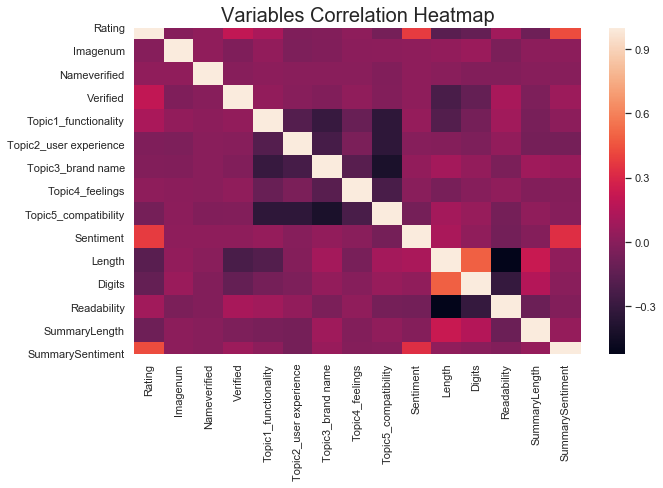

In [2138]:
plt.figure(figsize=(10,6))
sns.heatmap(df[features].corr(), annot=False)
plt.title("Variables Correlation Heatmap", fontsize=20)
plt.savefig('Plots/Variables Correlation Heatmap.png')

### Export data

In [2139]:
df[features]

,Rating,Imagenum,Nameverified,Verified,Topic1_functionality,Topic2_user experience,Topic3_brand name,Topic4_feelings,Topic5_compatibility,Sentiment,Length,Digits,Readability,SummaryLength,SummarySentiment
0,5.0,0,1.0,1,0.18152,0.13299,0.25247,0.05626,0.37677,0.9981,780,1,-703.31,5,0.6369
1,5.0,0,0.0,1,0.21474,0.13793,0.24374,0.05937,0.34421,0.8232,267,0,-182.62,4,0.6369
2,4.0,0,0.0,1,0.17763,0.16719,0.24718,0.05738,0.35063,0.9947,917,0,34.84,4,0.2500
3,5.0,0,0.0,1,0.19793,0.13864,0.24873,0.06086,0.35384,0.6369,2,0,120.21,2,0.0000
4,5.0,0,0.0,1,0.20037,0.13743,0.24683,0.06033,0.35505,0.4753,16,0,80.62,2,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,1.0,0,0.0,0,0.18759,0.14428,0.24900,0.06230,0.35683,0.9287,213,3,42.76,10,-0.4767
2563,5.0,0,0.0,1,0.19704,0.13864,0.24873,0.06174,0.35384,0.4404,1,0,121.22,2,0.0000
2564,5.0,0,0.0,1,0.19064,0.13708,0.24595,0.05860,0.36773,0.4325,82,3,67.59,28,0.8795
2565,5.0,0,0.0,1,0.18627,0.14087,0.26606,0.05957,0.34722,0.2500,32,0,80.62,2,0.5719


In [2140]:
subdf = df[features]
subdf['score'] = df['score']
subdf.to_csv('keyboard_data.csv', index = False)

### Model

In [2141]:
df = pd.read_csv('keyboard_data.csv')

#### Model Class

In [2142]:
df.columns

Index(['Rating', 'Imagenum', 'Nameverified', 'Verified',
       'Topic1_functionality', 'Topic2_user experience', 'Topic3_brand name',
       'Topic4_feelings', 'Topic5_compatibility', 'Sentiment', 'Length',
       'Digits', 'Readability', 'SummaryLength', 'SummarySentiment', 'score'],
      dtype='object')

In [2143]:
def render_table(data, col_width = 3.0, row_height = 0.625, font_size = 14,
                     header_color = '#40466e', row_colors = ['#f1f1f2', 'w'], edge_color = 'w',
                     bbox = [0, 0, 1, 1], header_columns = 0, ax = None, **kwargs):
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText = data.values, bbox = bbox, colLabels = data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight = 'bold', color = 'w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [2144]:
df[features]

,Rating,Imagenum,Nameverified,Verified,Topic1_functionality,Topic2_user experience,Topic3_brand name,Topic4_feelings,Topic5_compatibility,Sentiment,Length,Digits,Readability,SummaryLength,SummarySentiment
0,5.0,0,1.0,1,0.18152,0.13299,0.25247,0.05626,0.37677,0.9981,780,1,-703.31,5,0.6369
1,5.0,0,0.0,1,0.21474,0.13793,0.24374,0.05937,0.34421,0.8232,267,0,-182.62,4,0.6369
2,4.0,0,0.0,1,0.17763,0.16719,0.24718,0.05738,0.35063,0.9947,917,0,34.84,4,0.2500
3,5.0,0,0.0,1,0.19793,0.13864,0.24873,0.06086,0.35384,0.6369,2,0,120.21,2,0.0000
4,5.0,0,0.0,1,0.20037,0.13743,0.24683,0.06033,0.35505,0.4753,16,0,80.62,2,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,1.0,0,0.0,0,0.18759,0.14428,0.24900,0.06230,0.35683,0.9287,213,3,42.76,10,-0.4767
2563,5.0,0,0.0,1,0.19704,0.13864,0.24873,0.06174,0.35384,0.4404,1,0,121.22,2,0.0000
2564,5.0,0,0.0,1,0.19064,0.13708,0.24595,0.05860,0.36773,0.4325,82,3,67.59,28,0.8795
2565,5.0,0,0.0,1,0.18627,0.14087,0.26606,0.05957,0.34722,0.2500,32,0,80.62,2,0.5719


In [2145]:
class features_selection:
    '''
    This class takes the cleaned review data and apply three ways (random forest, linear regression, lasso regression) for selecting predictive features.
    '''
    def __init__(self, df, rating = 'all'):
        
        self.rating = rating
        self.df = df
        self.out = pd.DataFrame()
 
    def data_preprocessing(self):
        if self.rating == 'all':
            self.df = df
        elif self.rating == 'pos':
            self.df = df[df['Rating']>3]
        elif self.rating == 'neg':
            self.df = df[df['Rating']<3]
        elif self.rating == 'neu':
            self.df = df[df['Rating']==3]
        else:
            print('wrong input')
         
                
        # Select features that capture information that customers would see when reading reviews
        self.X = self.df[features]
        self.y = self.df['score']
        
        #print(self.X.shape, self.y.shape)
        
        # Divide the data into training and test set, with ratio 3:1 (test=20%).
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, random_state = 0)
        # Standarization
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.fit_transform(self.X_test)
        
        self.out["features"] = self.X.columns
        
    def label(self):
        '''
        Return full name for plotting graphs
        '''
        if self.rating == 'all':
            return "for All Reviews in the Sample"
        elif self.rating == 'pos':
            return "for Positive Reviews in the Sample"
        elif self.rating == 'neg':
            return "for Negative Reviews in the Sample"
        elif self.rating == 'neu':
            return "for Neutral Reviews in the Sample"
        else:
            return None
        
    def random_forest(self):
        '''
        Feature importance using Random Forest
        '''
        self.data_preprocessing()
        rfr = RandomForestRegressor(n_estimators = 100, n_jobs = 4).fit(self.X_train, self.y_train)
        imp = pd.DataFrame({"features": self.X.columns, "rfr_select": rfr.feature_importances_})
        imp = imp.sort_values(by='rfr_select', ascending=False)
        imp = imp.round(2)
        
        render_table(imp)
        rfr_title = "Random Forest Feature Importance Results " + self.label()
        plt.title(rfr_title, fontsize=12)
        #plt.savefig("Plots/"+rfr_title)
        plt.close()
        
        self.out['rfr_select'] = rfr.feature_importances_
        self.out['rfr_imp'] = np.where(rankdata(rfr.feature_importances_)>10, 1, 0)
        
        plt.figure(figsize = (12,8))
        plt.hlines(y = imp["features"], xmin = 0, xmax = imp['rfr_select'],
           linestyles = 'dashed', color = 'maroon')

        plt.plot(imp['rfr_select'], imp["features"], ">", color = 'maroon')

        plt.yticks(imp["features"])
        title = "Random Forest Variable Importance Plot" + self.label()
        plt.title(title, loc = 'center', fontsize = 20)
        plt.xlabel('scores')
        plt.savefig("Plots/"+title + '.png')
        plt.close()
        
        
        
    def linear(self):
        '''
        Fit the linear model with Ordinary Least Square
        '''
        self.data_preprocessing()
        lin = LinearRegression().fit(self.X_train, self.y_train)
        linkf = cross_val_score(lin, self.X_train, self.y_train, cv=5, scoring="neg_mean_squared_error")
        #print("Mean:",round(-linkf.mean(),2))
        #print("Standard deviation:",round(linkf.std(),2))
        
        self.X2 = sm.add_constant(self.X_train)
        model = sm.OLS(self.y_train, self.X2).fit()
        #predictions = model.predict(X) 
        print_model = model.summary()
        #print(print_model)
        
        Xcols = [i for i in self.X.columns]
        Xcols.insert(0, 'Intercept')
        output = pd.DataFrame({'Columns':Xcols, 'Coefficients':model.params, 'Std': model.bse, 'p_value':model.pvalues,
                             'Significant at 95% level':np.where(model.pvalues<0.05,1,0)}).round(2)
        
        self.out['linear_select'] = [i for i in model.params[1:]]
        self.out['linear_imp'] = np.where(model.pvalues[1:]<0.05,1,0)
        
        render_table(output)
        linear_title = "Linear Regression Results " + self.label()
        plt.title(linear_title, fontsize=20)
        plt.savefig("Plots/"+linear_title)
        plt.close()
        
        #return [(Xcols[i], model.params[i].round(2))  for i in range(len(Xcols)) if np.where(model.pvalues<0.05,1,0)[i]==1]
    
        
    def lasso(self):
        '''
        Fit the lasso model
        '''
        self.data_preprocessing()
        las = Lasso().fit(self.X_train, self.y_train)
        alpha_grid = {"alpha": np.linspace(0,10,50)}
        grid_search_las = GridSearchCV(las, param_grid = alpha_grid, n_jobs = 4, cv = 5,
                               scoring='neg_mean_squared_error').fit(self.X_train, self.y_train)

        #print('GridBestEstimatorLasso=', grid_search_las.best_estimator_)
        #print('GridBestParamsLasso=', grid_search_las.best_params_)
        #print('GridBestScoreLasso=', -grid_search_las.best_score_)
        
        las = Lasso(alpha = grid_search_las.best_params_['alpha']).fit(self.X_train, self.y_train)
        laskf = cross_val_score(las, self.X_train, self.y_train, cv = 5, 
                              scoring="neg_mean_squared_error")
        #print("Mean:", round(-laskf.mean(),2))
        #print("Standard deviation:",round(laskf.std(),2))
        lasso_output = pd.DataFrame({"features": self.X.columns, "Coefficients": las.coef_}).round(2)
        
        self.out['lasso_select'] = las.coef_
        self.out['lasso_imp'] = np.where(rankdata(np.abs(las.coef_))>10, 1, 0)
        
        render_table(lasso_output)
        lasso_title = "Lasso Regression Results " + self.label()
        plt.title(lasso_title, fontsize=12)
        #plt.savefig("Plots/"+lasso_title)
        plt.close()
        
        ## print lasso path
        ### https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html
        
        self.nrows, self.ncols = self.X.shape

        eps = 5e-8  # the smaller it is the longer is the path eps = alpha_min / alpha_max = 1e-3

        self.alphas_lasso, self.coefs_lasso, _ = linear_model.lasso_path(self.X_train, self.y_train, eps, fit_intercept=True)

        # Display results
        plt.figure(figsize = (12,8))
        #neg_log_alphas_lasso = -np.log10(alphas_lasso)

        for i in range(self.ncols):
            plt.plot(self.alphas_lasso, self.coefs_lasso[i], label = [i for i in self.X.columns][i])

        plt.xscale('log')
        plt.xlabel('Log($\\lambda$)')
        plt.ylabel('coefficients')
        path_title = "Lasso Path at Different Lambda " + self.label()
        plt.title(path_title, fontsize=20)
        plt.legend()
        plt.axis('tight')  
        plt.savefig("Plots/"+path_title + '.png')
        plt.close()
        
    def output(self):
        self.random_forest()
        self.linear()
        self.lasso()
        self.out['imp_agg'] = self.out['rfr_imp']+self.out['linear_imp']+self.out['lasso_imp']
        self.out = self.out.sort_values(by='imp_agg', ascending=False).round(2)
        
        # correlation (which method correlates most with the majority vote)
        rfr_corr = np.corrcoef(self.out['imp_agg'], self.out['rfr_imp'])[0,1].round(2)
        linear_corr = np.corrcoef(self.out['imp_agg'], self.out['linear_imp'])[0,1].round(2)
        lasso_corr = np.corrcoef(self.out['imp_agg'], self.out['lasso_imp'])[0,1].round(2)
        print("Random Forest:", rfr_corr, "Linear:", linear_corr, "Lasso:", lasso_corr)
        
        render_table(self.out)
        output_title = "Ensemble Variable Importance Results " + self.label()
        plt.title(output_title, fontsize=20)
        plt.savefig("Plots/"+output_title)
        plt.close()
        
    
        return self.out
                              


#### Full data

In [2146]:
df_full = features_selection(df, 'all')
df_full.output()

Random Forest: 0.47 Linear: 0.8 Lasso: 0.9


,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,imp_agg
10,Length,0.25,1,2258.75,1,2094.15,1,3
0,Rating,0.02,0,-285.04,1,-244.65,1,2
8,Topic5_compatibility,0.09,1,13384.29,0,101.16,1,2
13,SummaryLength,0.07,0,-550.29,1,-327.45,1,2
14,SummarySentiment,0.06,0,246.18,1,179.13,1,2
4,Topic1_functionality,0.08,1,10878.77,0,-67.15,0,1
5,Topic2_user experience,0.08,1,12453.16,0,-0.00,0,1
6,Topic3_brand name,0.08,1,16317.69,0,0.00,0,1
1,Imagenum,0.00,0,-226.03,0,-0.00,0,0
2,Nameverified,0.01,0,-4.63,0,-0.00,0,0


#### Subset: Positive Reviews

In [2147]:
df_positive = features_selection(df, 'pos')
df_positive = df_positive.output()
df_positive

Random Forest: 0.71 Linear: 0.75 Lasso: 0.84


,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,imp_agg
10,Length,0.26,1,1706.53,1,1701.02,1,3
13,SummaryLength,0.08,1,-592.12,1,-532.59,1,3
8,Topic5_compatibility,0.09,1,-130552.74,0,314.43,1,2
12,Readability,0.07,0,-565.53,1,-471.35,1,2
0,Rating,0.01,0,-100.51,1,-97.90,0,1
5,Topic2_user experience,0.08,1,-122685.81,0,-0.00,0,1
6,Topic3_brand name,0.09,1,-125224.27,0,267.15,0,1
11,Digits,0.01,0,320.27,0,275.45,1,1
1,Imagenum,0.00,0,382.97,0,0.00,0,0
2,Nameverified,0.01,0,23.53,0,18.73,0,0


#### Subset: Negative Reviews

In [2148]:
df_negative = features_selection(df, 'neg')
df_negative = df_negative.output()
df_negative

Random Forest: 0.51 Linear: 0.69 Lasso: 0.81


,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,imp_agg
10,Length,0.26,1,1497.84,1,1084.11,1,3
1,Imagenum,0.00,0,1183.99,1,666.70,1,2
5,Topic2_user experience,0.09,1,-193153.90,0,451.48,1,2
14,SummarySentiment,0.05,0,497.29,1,397.14,1,2
3,Verified,0.01,0,-255.11,1,-236.88,0,1
4,Topic1_functionality,0.10,1,-175519.67,0,-76.73,0,1
6,Topic3_brand name,0.08,1,-194569.44,0,-135.71,0,1
8,Topic5_compatibility,0.10,1,-225899.88,0,0.00,0,1
12,Readability,0.08,0,-582.03,0,-402.54,1,1
0,Rating,0.01,0,-47.58,0,-42.86,0,0


#### Subset: Neutral Reviews

In [2149]:
df_neutral = features_selection(df, 'neu')
df_neutral = df_neutral.output()
df_neutral

Random Forest: 0.8 Linear: 0.84 Lasso: 0.8


,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,imp_agg
10,Length,0.25,1,1391.76,1,972.48,1,3
13,SummaryLength,0.09,1,-709.64,1,-265.42,1,3
8,Topic5_compatibility,0.09,1,72609.90,0,219.48,1,2
9,Sentiment,0.10,1,-419.99,1,-160.33,0,2
14,SummarySentiment,0.05,0,632.37,1,256.60,1,2
3,Verified,0.01,0,-247.74,0,-220.54,1,1
4,Topic1_functionality,0.10,1,67602.78,0,-0.00,0,1
0,Rating,0.00,0,0.00,0,0.00,0,0
1,Imagenum,0.00,0,0.00,0,0.00,0,0
2,Nameverified,0.01,0,44.95,0,0.00,0,0


#### Aggregate barchart

In [2150]:
df_positive['group'] = ["positive"]*15
df_neutral['group'] = ["neutral"]*15
df_negative['group'] = ["negative"]*15
df_agg = pd.concat([df_positive, df_neutral, df_negative], axis=0)
df_agg_grouped = df_agg.groupby('features')['imp_agg'].sum()
df_agg = df_agg.merge(df_agg_grouped, on='features')
df_agg = df_agg.rename(columns={'imp_agg_x': 'importance votes'})
df_agg.sort_values(by='importance votes', ascending=False, inplace=True)

In [2151]:
df_agg

,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,importance votes,group,imp_agg_y
0,Length,0.26,1,1706.53,1,1701.02,1,3,positive,9
2,Length,0.26,1,1497.84,1,1084.11,1,3,negative,9
3,SummaryLength,0.08,1,-592.12,1,-532.59,1,3,positive,6
4,SummaryLength,0.09,1,-709.64,1,-265.42,1,3,neutral,6
1,Length,0.25,1,1391.76,1,972.48,1,3,neutral,9
17,Topic2_user experience,0.09,1,-193153.90,0,451.48,1,2,negative,3
43,SummarySentiment,0.05,0,632.37,1,256.60,1,2,neutral,4
40,Sentiment,0.10,1,-419.99,1,-160.33,0,2,neutral,2
26,Imagenum,0.00,0,1183.99,1,666.70,1,2,negative,2
44,SummarySentiment,0.05,0,497.29,1,397.14,1,2,negative,4


In [2152]:
df_agg['features'].unique()

array(['Length', 'SummaryLength', 'Topic2_user experience',
       'SummarySentiment', 'Sentiment', 'Imagenum',
       'Topic5_compatibility', 'Readability', 'Digits',
       'Topic3_brand name', 'Verified', 'Topic1_functionality', 'Rating',
       'Topic4_feelings', 'Nameverified'], dtype=object)

In [2153]:
np.arange(0,3,1)

array([0, 1, 2])

<Figure size 1800x432 with 0 Axes>

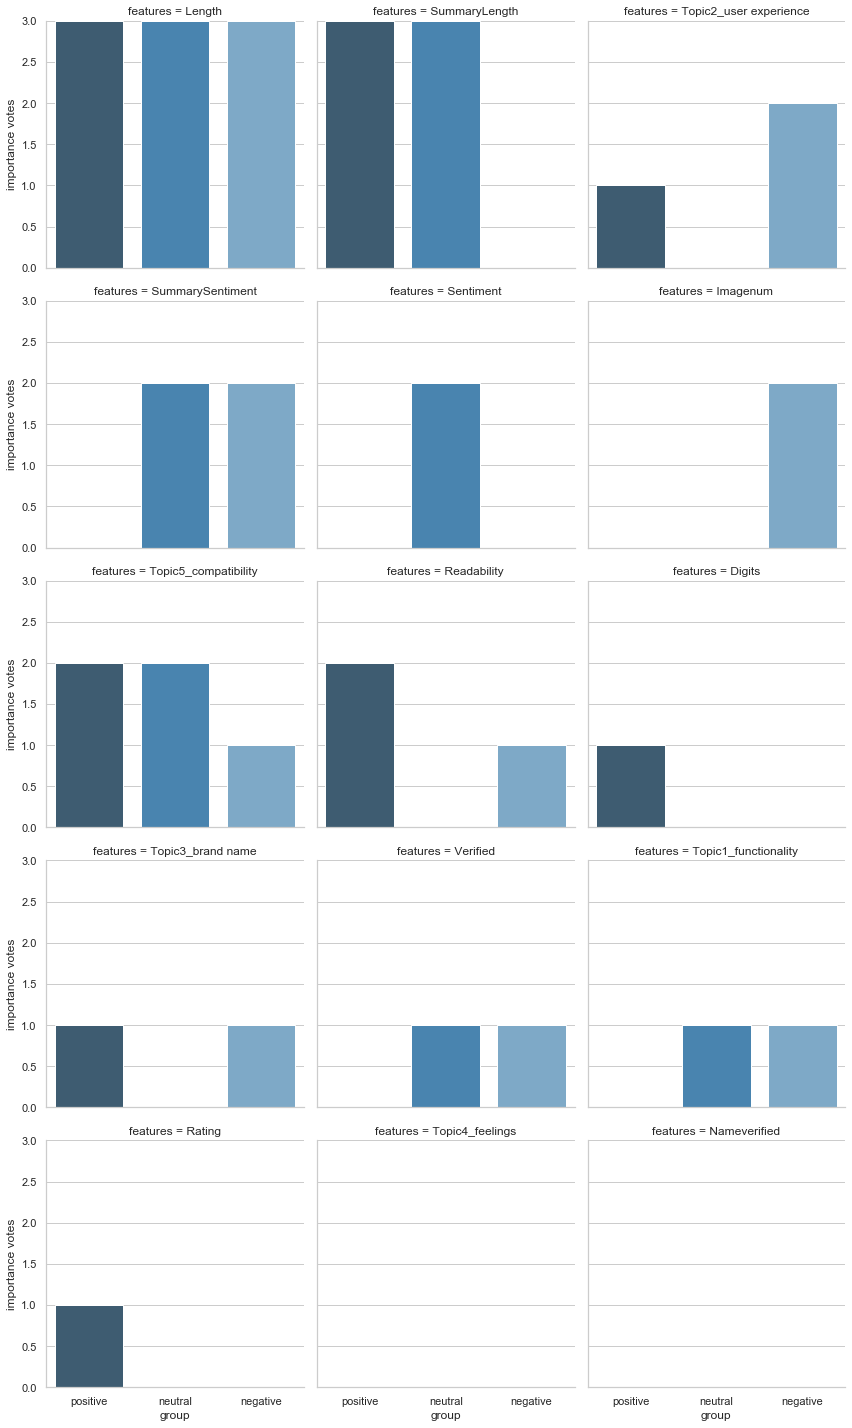

In [2156]:
sns.set(style="whitegrid")
plt.figure(figsize = (25,6))
g = sns.FacetGrid(df_agg, col="features",  col_wrap=3, size=4, ylim=(0, 3))
g.map(sns.barplot, "group", "importance votes", color=".9", 
      palette='Blues_d', order = ["positive", "neutral", "negative"])
    
plt.savefig("Plots/Importance Votes of 15 Variables at Positive, Neutral, and Negative Reviews.png")

In [2155]:
## Running time
end = time.time()
(end - start)/60

8.02240004936854